<a href="https://colab.research.google.com/github/fabiocarrara/mbd-dlmra/blob/main/ol2_image_representation_search_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLMRA OpenLab \#2
-----------------

# Image Representations for Similarity Search, Clustering, and Classification

You'll learn to:

*   Represent images using features extracted from pretrained CNNs.
*   Search images by visual similarity in an image database and evaluate results.
*   Cluster an image database by visual similarity.
*   Build simple image classifiers based on pretrained representations.


## Getting Started

We will use [Kaggle](https://www.kaggle.com/) as our source of datasets. This let us download datasets directly from Kaggle to Colab without manually upload the data at the beginning of every session.

- Register on Kaggle (you can login with a Google Account).
- Go to Account Settings > "Account" Tab > Click on "Create New API Token".
- Save the generated `kaggle.json` file somewhere on your PC.

Next, we install the `kaggle` command line utility on Colab.

In [1]:
!pip install -q kaggle

Upload the `kaggle.json` file to Colab...

In [2]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


... and let's put it in the right place and give it the right file permissions.

In [3]:
%%bash
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Now, we can download datasets using the `kaggle`.
Let's download the dataset used in this exercise: `vikashrajluhaniwal/fashion-images`.

More info on the dataset on [its Kaggle page](https://www.kaggle.com/vikashrajluhaniwal/fashion-images).





In [4]:
!kaggle datasets download -d vikashrajluhaniwal/fashion-images --unzip

 98% 329M/335M [00:13<00:00, 33.1MB/s]
100% 335M/335M [00:13<00:00, 25.1MB/s]


In [5]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from pathlib import Path
from tqdm.auto import tqdm
from skimage.transform import resize

import matplotlib
import matplotlib.pyplot as plt

import random

%matplotlib inline

## Data Loading

Let's inspect the data.

In [97]:
image_paths = Path('data').rglob('*.jpg')
image_paths = sorted(image_paths)
image_paths[:5]

[PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10054.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10649.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10671.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/12840.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/12844.jpg')]

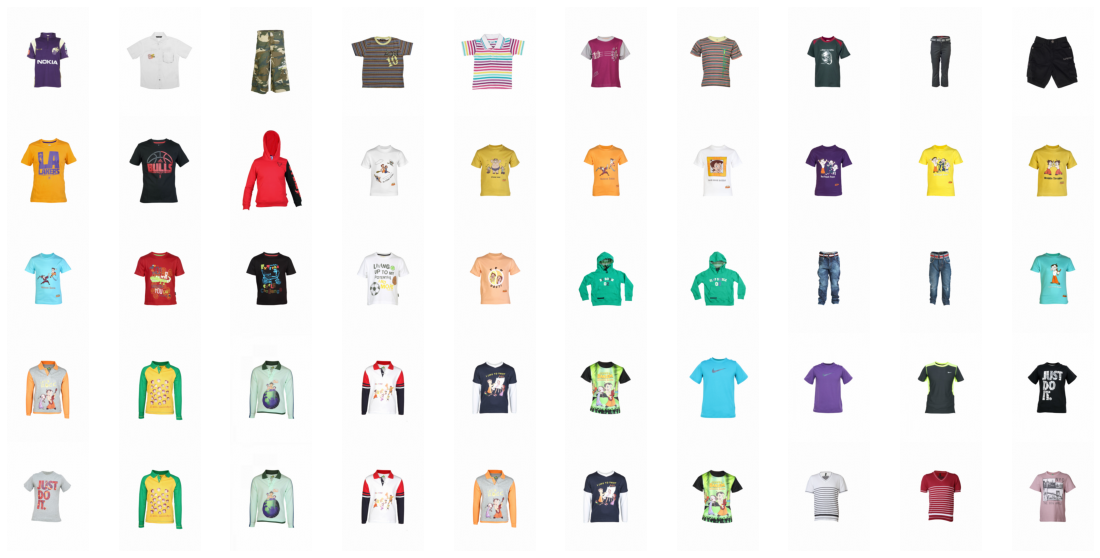

In [98]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for ax, image_path in zip(axes.flatten(), image_paths):
  image_np = plt.imread(image_path)
  image_np = resize(image_np, (400, 300))
  ax.imshow(image_np)
  ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

Consider a (potentially large) database of images and a set of query images.
Our goal is to retrieve images from the database that are visually similar to the queries.

Let's select from our dataset two subset of images that will comprise the *database* and the *queries*.

In [99]:
nq = 15  # number of queries
ndb = 500  # number of samples in the database

selected_image_paths = random.sample(image_paths, ndb + nq)
db_image_paths = selected_image_paths[:ndb]
q_image_paths = selected_image_paths[-nq:]
q_image_paths[:5]

[PosixPath('data/Footwear/Men/Images/images_with_product_ids/1636.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/2722.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/31102.jpg'),
 PosixPath('data/Footwear/Men/Images/images_with_product_ids/21188.jpg'),
 PosixPath('data/Apparel/Girls/Images/images_with_product_ids/34156.jpg')]

## Image Representation

We will use a pretrained model to extract features from images and use them as compact image representations.
The choice of the model is essential to get good representations for your target task (e.g. a model trained on classifying dog breeds will have a hard time creating good representations for images of flowers).

In [100]:
model1 = tf.keras.applications.EfficientNetB0(input_shape=(512, 384, 3), weights='imagenet', include_top=False, pooling='avg')

A lot of pretrained models are available on [TensorFlow Hub](https://tfhub.dev) and can be easily downloaded and used in Keras with the `tensorflow_hub.KerasLayer` API.

Check out [this list](https://tfhub.dev/google/collections/experts/bit/1) of Google's BiT models (Big Transfer, specifically thought for feature extraction) that are pretrained on specific subsets of the ImageNet-21k dataset.

_NOTE: If you need a specialized model, you will need to fine-tune a pretrained model on a small dataset of images you are interested in discerning._

In [101]:
# a model pretrained on ImageNet-21k
model2 = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1")
model3 = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/consumer_goods/1")

`model` is a Keras module that can be called on tensor images and returns a feature vector (2048-d for BiT models).

Let's prepare the model pipeline by defining input preprocessing and feature post-processing.

In [102]:
def load_image(path):
  image_data = tf.io.read_file(path)
  image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.expand_dims(image, axis=0)
  return image

def resize_images(images):
  # return tf.image.resize(images, (363, 272))
  return tf.image.resize(images, (512, 512), preserve_aspect_ratio=True)

def l2_normalize(feature_vector):
  return tf.math.l2_normalize(feature_vector, axis=1)

Let's extract feature vectors from a bunch of images. We use the `tf.data.Dataset` API (specifically `.map()`) to apply input preprocessing, feature extraction, and feature postprocessing.

_NOTE: when using `.map()`, all the processing is deferred. Data will be processed when we will iterate on the dataset asking for computation results._

In [103]:
def extract_features(image_paths, model):
  db = list(map(str, image_paths))
  db = tf.data.Dataset.from_tensor_slices(db)
  db = db.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  db = db.map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
  db = db.prefetch(5)

  features = db.map(model)  # apply model to get features
  features = features.map(l2_normalize)  # apply postprocessing (normalize features)

  total = len(features)
  features = features.as_numpy_iterator()  # we want results as numpy arrays
  features = tqdm(features, total=total)  # add a progress bar with tqdm
  features = list(features)  # get all features in a list 
  features = np.concatenate(features)  # concatenate rows to get a unique matrix
  return features

In [104]:
db_features_model1 = extract_features(db_image_paths, model1)
db_features_model2 = extract_features(db_image_paths, model2)
db_features_model3 = extract_features(db_image_paths, model3)

queries_features_model1 = extract_features(q_image_paths, model1)
queries_features_model2 = extract_features(q_image_paths, model2)
queries_features_model3 = extract_features(q_image_paths, model3)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [105]:
db_features = db_features_model1
queries_features = queries_features_model1

queries_features.shape, db_features.shape

((15, 1280), (500, 1280))

## Image Similarity Search

Once we have feature vectors representations, we can search similar by comparing the features vectors instead of pixels.

We will compare feature vectors using the cosine similarity
$$
 \cos(a, b) = \frac{a \cdot b}{\left\lVert a \right\rVert_2 \left\lVert b \right\rVert_2},
$$
that ranges between 0 (low similarity) and 1 (high similarity).

On normalized features ($\left\lVert a \right\rVert_2 = \left\lVert b \right\rVert_2 = 1$), the cosine similarity is equivalent to the dot product $a \cdot b$. 

Let's select some query images for which we want to retrieve similar images in our database.
We will perform a brute-force search (a.k.a. sequential scan) where we compare the queries' feature vectors with all the databases' feature vectors. (For $Q$ queries and $D$ database images, we will compute $N \times D$ scores).

We can compute all the dot products between queries $F_\text{q} \in \mathbb{R}^{Q \times 2048}$ and database feature vectors $F_\text{db} \in \mathbb{R}^{D \times 2048}$ using a single matrix multiplication
$$
S = \{s_{ij}\}= F_\text{q} F_\text{db}^T \,,
$$
where the $s_{ij}$ element of $S$ is the cosine similarity between the $i$-th query $f_\text{q}^i$ and the $j$-th database feature vector $f_\text{db}^j$
$$
s_{ij} = f_\text{q}^i \cdot f_\text{db}^j \,.
$$


In [106]:
scores = queries_features.dot(db_features.T)
scores.shape

(15, 500)

In [107]:
nq, ndb = scores.shape

k = 5
sorted_scores = scores.argsort(axis=1)[:, ::-1]  # sort descending per row
topk = sorted_scores[:, :k]  # get **indices** of the topk images for each row

topk_scores = np.stack([scores[i, topk[i]] for i in range(nq)])  # get topk scores (comprehensible version)
# topk_scores = scores[np.arange(nq)[:, None], topk]  # use the indices to get the topk scores (magic slicing version)

topk_scores

array([[1.0000005, 1.0000005, 1.0000004, 1.0000004, 1.0000004],
       [1.0000004, 1.0000002, 1.0000002, 1.0000002, 1.0000002],
       [1.0000002, 1.0000002, 1.0000001, 1.0000001, 1.0000001],
       [1.0000005, 1.0000004, 1.0000004, 1.0000002, 1.0000002],
       [1.0000001, 1.0000001, 1.0000001, 1.0000001, 1.0000001],
       [1.0000005, 1.0000005, 1.0000004, 1.0000004, 1.0000004],
       [1.0000006, 1.0000006, 1.0000005, 1.0000005, 1.0000004],
       [1.0000005, 1.0000004, 1.0000002, 1.0000002, 1.0000002],
       [1.0000005, 1.0000004, 1.0000004, 1.0000002, 1.0000002],
       [1.0000004, 1.0000002, 1.0000002, 1.0000002, 1.0000002],
       [1.0000004, 1.0000004, 1.0000002, 1.0000002, 1.0000002],
       [1.0000005, 1.0000004, 1.0000004, 1.0000004, 1.0000002],
       [1.0000005, 1.0000004, 1.0000002, 1.0000002, 1.0000002],
       [1.0000004, 1.0000004, 1.0000004, 1.0000002, 1.0000002],
       [1.0000005, 1.0000004, 1.0000004, 1.0000004, 1.0000002]],
      dtype=float32)

Let's define a helper function to select some images from a `tf.data.Dataset` pipeline.

In [108]:
def unpad_image(image_np):
    # remove some whitespace around the images
    image_np = np.stack([image_np, image_np, image_np], axis=-1) if image_np.ndim < 3 else image_np
    rr, cc = np.nonzero((image_np != 255).any(axis=2))
    y0, y1 = rr.min(), rr.max()
    x0, x1 = cc.min(), cc.max()
    return image_np[y0:y1+1, x0:x1+1]

def show_images(paths, figsize=None):
  n_images = len(paths)
  fig, axes = plt.subplots(1, n_images, figsize=figsize)
  for ax, path in zip(axes, paths):
    image_np = plt.imread(path)
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (363, 266))
    ax.imshow(image_np)
    ax.set_xticks([])
    ax.set_yticks([])
  
  return fig

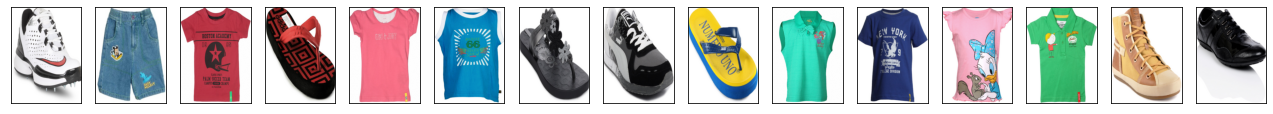

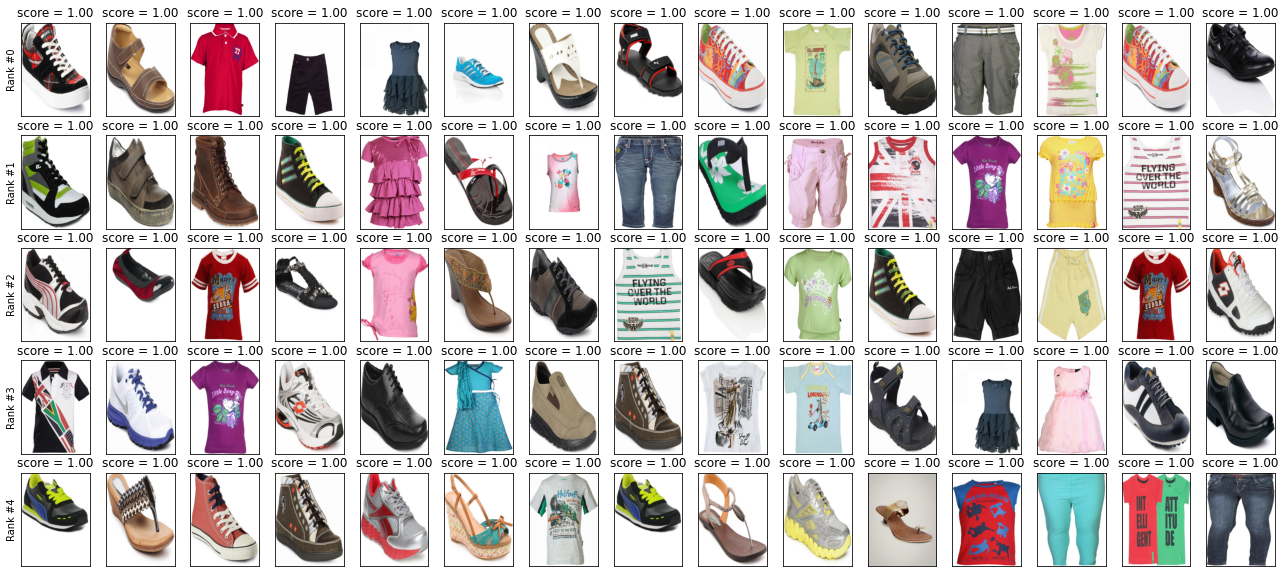

In [109]:
# show queries
fig = show_images(q_image_paths, figsize=(1.5*nq, 5))

# show topk similar 
fig, axes = plt.subplots(k, nq, figsize=(fig.get_figwidth(), 2*k))
for j in range(k):
  axes[j, 0].set_ylabel(f'Rank #{j}')
  for i in range(nq):
    image_np = plt.imread(db_image_paths[topk[i, j]])
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (363, 266))
    axes[j, i].imshow(image_np)
    axes[j, i].set_title('score = {:.2f}'.format(topk_scores[i, j]))
    axes[j, i].set_xticks([])
    axes[j, i].set_yticks([])

Let's now evaluate the retrieved results. Since our set is annotated, we consider a result **relevant** for a query if they belong to the same category label.

First, we import the annotation available in our dataset.

In [110]:
annot = pd.read_csv('data/fashion.csv', index_col=0)
annot

Gender  Category SubCategory   ProductType Colour   Usage  \
ProductId                                                             
42419      Girls   Apparel     Topwear          Tops  White  Casual   
34009      Girls   Apparel     Topwear          Tops  Black  Casual   
40143      Girls   Apparel     Topwear          Tops   Blue  Casual   
23623      Girls   Apparel     Topwear          Tops   Pink  Casual   
47154      Girls   Apparel  Bottomwear        Capris  Black  Casual   
...          ...       ...         ...           ...    ...     ...   
51755      Women  Footwear       Shoes  Casual Shoes  Black  Casual   
47630      Women  Footwear       Shoes         Flats   Blue  Casual   
32836      Women  Footwear       Shoes         Flats   Pink  Casual   
35821      Women  Footwear       Shoes         Heels  Black  Casual   
18553      Women  Footwear       Shoes         Heels   Blue  Casual   

                                          ProductTitle      Image  \
ProductId                                                           
42419               Gini and Jony Girls Knit White Top  42419.jpg   
34009                    Gini and Jony Girls Black Top  34009.jpg   
40143      Gini and Jony Girls Pretty Blossom Blue Top  40143.jpg   
23623       Doodle Kids Girls Pink I love Shopping Top  23623.jpg   
47154                 Gini and Jony Girls Black Capris  47154.jpg   
...                                                ...        ...   
51755                        Catwalk Women Black Shoes  51755.jpg   
47630                  Carlton London Women Blue Shoes  47630.jpg   
32836                 Grendha Women Flori Pink Sandals  32836.jpg   
35821                        Enroute Women Black Heels  35821.jpg   
18553              Catwalk Women Mary Janes Blue Flats  18553.jpg   

                                                    ImageURL  
ProductId                                                     
42419      http://assets.myntassets.com/v1/images/style/p...  
34009      http://assets.myntassets.com/v1/images/style/p...  
40143      http://assets.myntassets.com/v1/images/style/p...  
23623      http://assets.myntassets.com/v1/images/style/p...  
47154      http://assets.myntassets.com/v1/images/style/p...  
...                                                      ...  
51755      http://assets.myntassets.com/v1/images/style/p...  
47630      http://assets.myntassets.com/v1/images/style/p...  
32836      http://assets.myntassets.com/v1/images/style/p...  
35821      http://assets.myntassets.com/v1/images/style/p...  
18553      http://assets.myntassets.com/v1/images/style/p...  

[2906 rows x 9 columns]

We will build our groundtruth based on the **`Category`** column. Let's select the category labels for our queries and dataset.

In [111]:
db_image_ids = [int(p.stem) for p in db_image_paths]
q_image_ids = [int(p.stem) for p in q_image_paths]

db_labels = annot.loc[db_image_ids].Category
q_labels = annot.loc[q_image_ids].Category

We build a groundtruth matrix where `groundtruth[i,j]` is `True` if the database sample `j` is relevant for the query `i`.

In [112]:
groundtruth = np.empty((nq, ndb), dtype=bool)
for i, qi_label in enumerate(q_labels):
  for j, dbj_label in enumerate(db_labels):
    groundtruth[i, j] = (qi_label == dbj_label)

groundtruth

array([[ True,  True, False, ..., False, False,  True],
       [False, False,  True, ...,  True,  True, False],
       [False, False,  True, ...,  True,  True, False],
       ...,
       [False, False,  True, ...,  True,  True, False],
       [ True,  True, False, ..., False, False,  True],
       [ True,  True, False, ..., False, False,  True]])

Given the score matrix (`scores`) and the groundtruth matrix (`groundtruth`), we can compute several metrics. Here, we use sklearn's [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) that computes the average precision (AP) for a single query/result pair. We then report the mean among all the queries (mean Average Precision or mAP).

**Note:** for simplicity, we are evaluating the entire result set, whereas usually, only the top `k` retrieved elements are considered when computing the mAP.

In [113]:
from sklearn.metrics import average_precision_score

def compute_mean_ap(groundtruth, scores):
  aps = []
  for groundtruth_i, scores_i in zip(groundtruth, scores):
    ap = average_precision_score(groundtruth_i, scores_i)
    aps.append(ap)

  return np.mean(aps)

In [114]:
compute_mean_ap(groundtruth, scores)

0.5238907231204865

Let's compare the three models we have used:

In [115]:
scores1 = queries_features_model1.dot(db_features_model1.T)
scores2 = queries_features_model2.dot(db_features_model2.T)
scores3 = queries_features_model3.dot(db_features_model3.T)

mean_ap1 = compute_mean_ap(groundtruth, scores1)
mean_ap2 = compute_mean_ap(groundtruth, scores2)
mean_ap3 = compute_mean_ap(groundtruth, scores3)

print(f'EffNetB0 (IN-1k):     mAP={mean_ap1:.2%}')
print(f'BiT (IN-21k):         mAP={mean_ap2:.2%}')
print(f'BiT (Consumer Goods): mAP={mean_ap3:.2%}')

EffNetB0 (IN-1k):     mAP=52.39%
BiT (IN-21k):         mAP=99.50%
BiT (Consumer Goods): mAP=98.91%


## Image Clustering

Image representations can be used to explore an image dataset via clustering.
We will use kMeans on feature vectors to group similar images together.

In [116]:
import itertools
from collections import Counter
from sklearn.cluster import KMeans

In [117]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit_predict(db_features)  # run kmeans on the db features to find centroids
# kmeans.cluster_centers_  # uncomment to see the cluster centroids

array([ 7,  1,  0, 11, 14,  6,  6,  0,  4, 13, 11,  5,  0,  3,  7, 15, 19,
        7, 11,  1,  0,  7, 11, 14, 14, 18,  7,  7,  0, 11,  1, 13, 11,  0,
       12, 11, 11, 11, 18, 11,  5,  7, 14,  9,  4, 11,  7,  0,  4,  4, 17,
       14, 15, 14,  7, 16,  1,  7,  0,  7,  7, 18,  1,  1, 13, 18,  4, 14,
       13, 11, 15, 14, 15, 14, 16,  4, 15,  5,  5,  0,  7,  1, 18, 11, 15,
        2, 13,  7,  0,  1, 11, 10, 11,  6,  1,  1, 15, 11,  5, 11, 11, 13,
       16,  0, 14,  7,  1,  7,  6, 17, 12, 19, 14, 12,  0, 12, 16,  0, 16,
        1, 11, 11,  2,  7, 11, 17, 15, 14,  7, 16, 11, 11,  0, 14,  6,  4,
       18, 12,  7,  7, 10,  1,  6,  1, 14, 11, 11, 17,  1,  1, 13,  7,  4,
        0,  1,  6, 18,  0, 18,  4,  1,  6, 12, 15,  7,  5,  0, 18, 12, 14,
       14, 14,  0, 18,  1, 13,  7, 15, 18,  0,  0, 11,  0,  7, 12, 15, 10,
       14,  4,  0,  7,  1,  6,  7, 16, 18, 12, 13, 14,  1,  1,  5, 12,  7,
       13,  4,  4,  0, 18,  3, 16, 11, 11,  0,  5, 14, 15, 18,  7,  6,  1,
       18,  1,  7, 13,  1

In [118]:
labels = kmeans.predict(db_features)  # assign each feature to the nearest cluster and return the cluster index

# let's see how images are distributed among clusters
counts = Counter(labels).most_common()  
for cluster_idx, n_images in counts:
  print(f'Cluster #{cluster_idx}: {n_images} samples')

Cluster #6: 71 samples
Cluster #14: 68 samples
Cluster #1: 42 samples
Cluster #11: 41 samples
Cluster #18: 34 samples
Cluster #0: 34 samples
Cluster #15: 33 samples
Cluster #7: 29 samples
Cluster #13: 28 samples
Cluster #12: 28 samples
Cluster #4: 27 samples
Cluster #16: 20 samples
Cluster #3: 15 samples
Cluster #5: 10 samples
Cluster #10: 6 samples
Cluster #17: 5 samples
Cluster #9: 3 samples
Cluster #19: 2 samples
Cluster #2: 2 samples
Cluster #8: 2 samples


It is often useful to visualize the 'most central' sample for each cluster, that is, the sample of that cluster that is nearest to its centroid.
We refer to these samples as the _representative_ ones. Let's find them.

In [119]:
distances_to_centroids = kmeans.transform(db_features)  # .transform() computes the distances between features and all centroids
representatives = distances_to_centroids.argmin(axis=0)  # for each centroid, we find the index of the sample with the smallest distance, that's the representative one.

Let's plot the clusters.

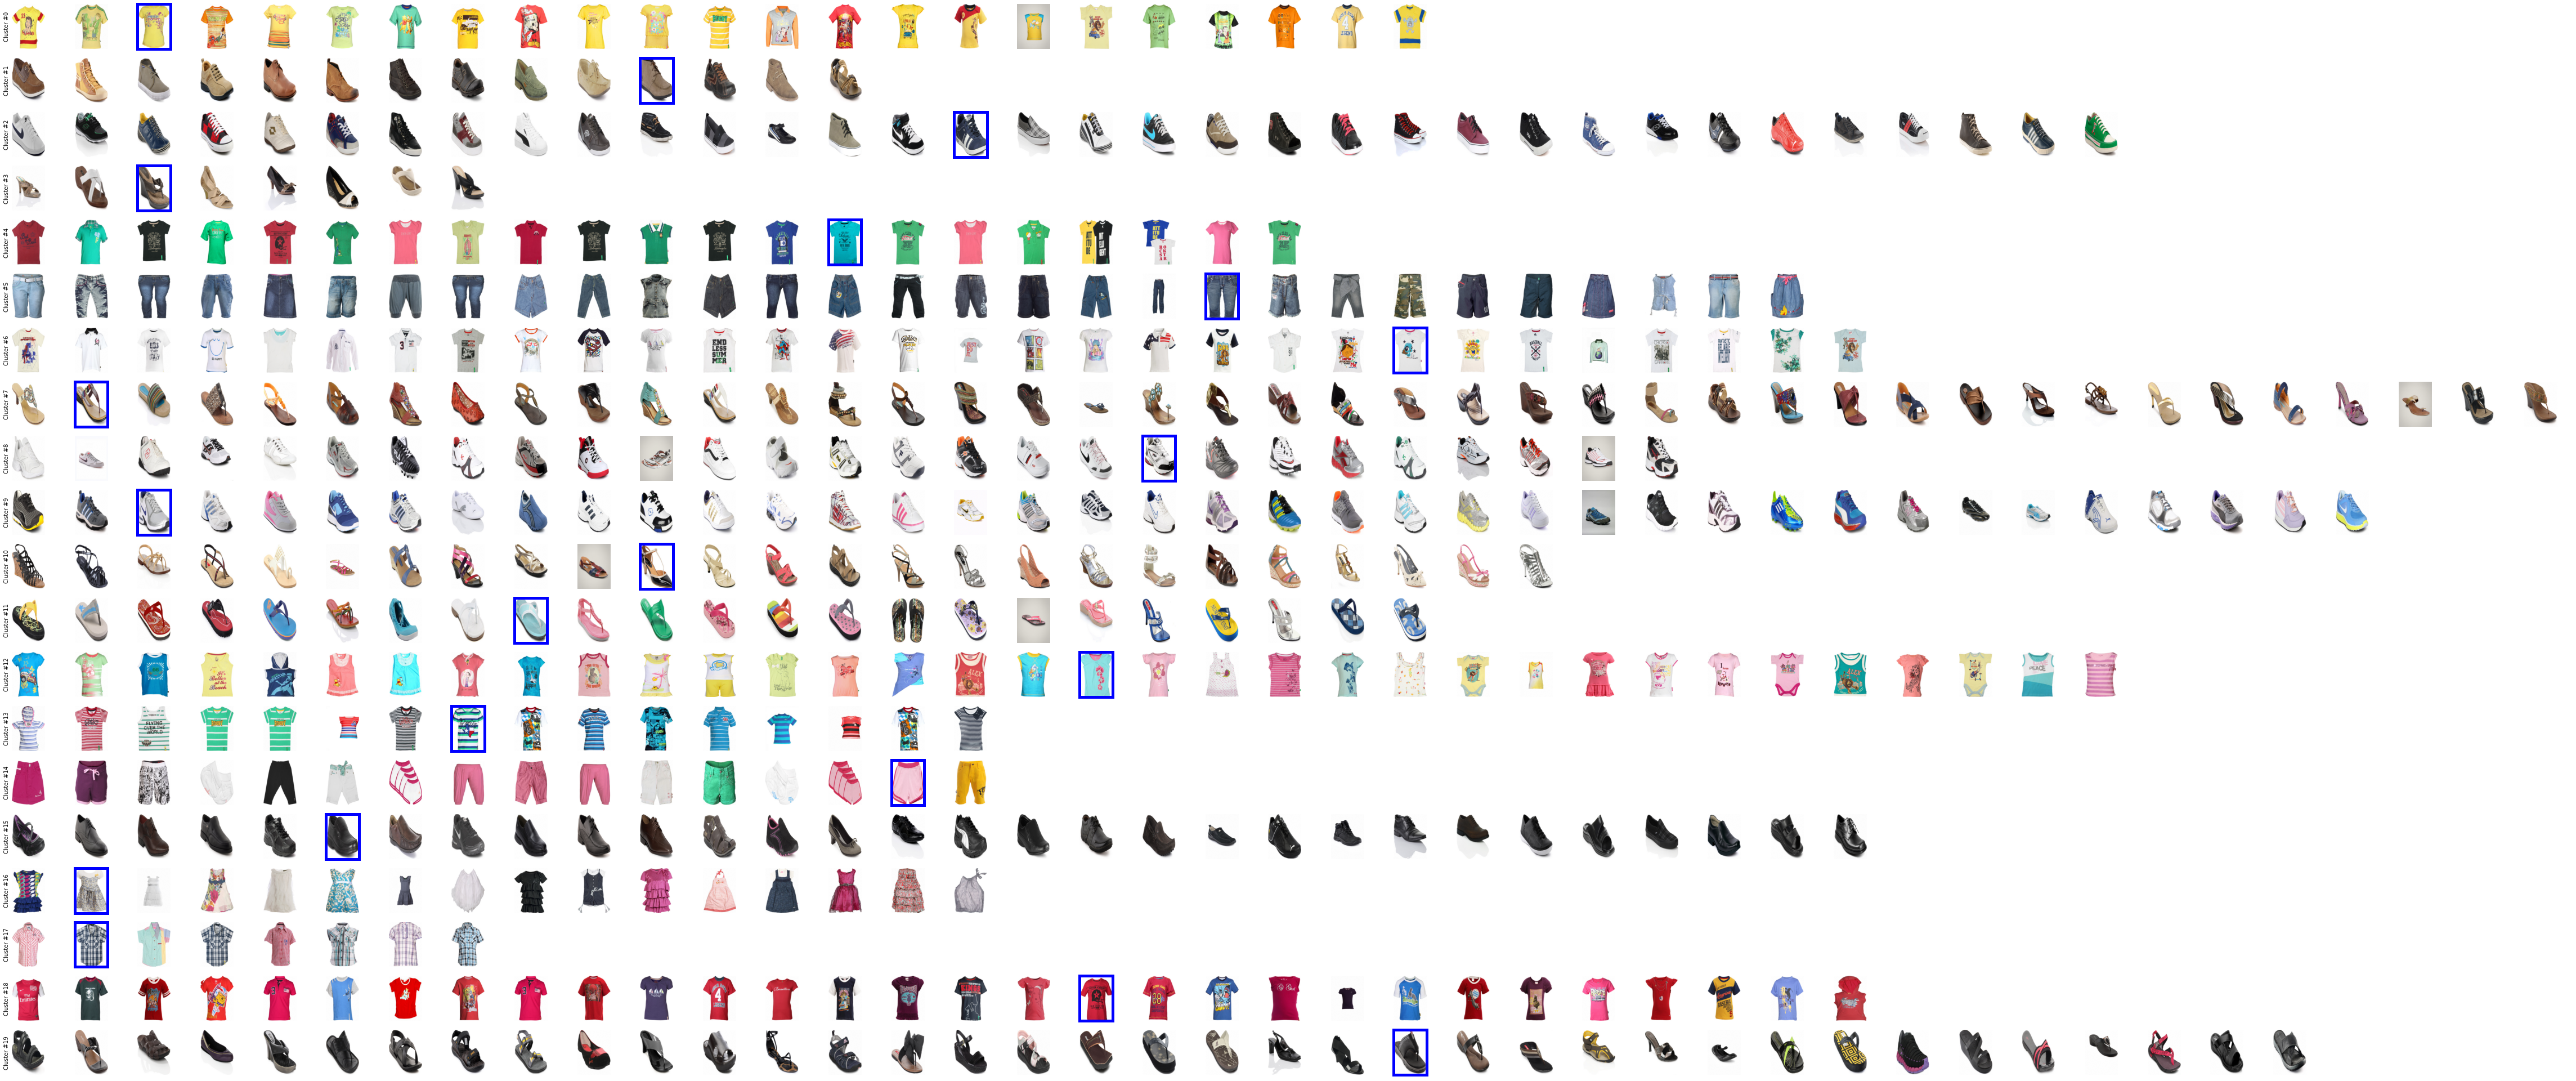

In [96]:
maxsize = counts[0][1]  # size of the biggest cluster
fig, axes = plt.subplots(n_clusters, maxsize, figsize=(2*maxsize, 1.75*n_clusters))

# hide ticks and spines
for ax in axes.flatten():
  ax.set_xticks([])
  ax.set_yticks([])
  plt.setp(ax.spines.values(), visible=False)

# we create cluster groups by sorting and grouping by cluster labels
labels_and_idx = [(l, i) for i, l in enumerate(labels)]
labels_and_idx = sorted(labels_and_idx)
cluster_groups = itertools.groupby(labels_and_idx, key=lambda x: x[0])

# for each group, we plot the belonging images in a row
for cluster_idx, cluster in cluster_groups:
  axes[cluster_idx, 0].set_ylabel(f'Cluster #{cluster_idx}')
  
  for i, (_, sample_idx) in enumerate(cluster):
    image_np = plt.imread(db_image_paths[sample_idx])
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (182, 133))
    axes[cluster_idx, i].imshow(image_np)

    # highlight the representative sample of the cluster
    if sample_idx in representatives:  
      plt.setp(axes[cluster_idx, i].spines.values(), edgecolor='blue', linewidth=5, visible=True)

plt.subplots_adjust(wspace=0)

## Image Classification via Transfer Learning


A good general representation can also be used to solve specialized tasks.
This is known as transfer learning, in which we transfer knowledge from a model pretrained on a more generic task to our specialized one.
This often has the advantage of needing way less data to solve the task.

Let's see how we can exploit the representation we extracted to build simple image classifiers.


First, we import the annotation available in our dataset.

In [120]:
annot = pd.read_csv('data/fashion.csv', index_col=0)
annot

Gender  Category SubCategory   ProductType Colour   Usage  \
ProductId                                                             
42419      Girls   Apparel     Topwear          Tops  White  Casual   
34009      Girls   Apparel     Topwear          Tops  Black  Casual   
40143      Girls   Apparel     Topwear          Tops   Blue  Casual   
23623      Girls   Apparel     Topwear          Tops   Pink  Casual   
47154      Girls   Apparel  Bottomwear        Capris  Black  Casual   
...          ...       ...         ...           ...    ...     ...   
51755      Women  Footwear       Shoes  Casual Shoes  Black  Casual   
47630      Women  Footwear       Shoes         Flats   Blue  Casual   
32836      Women  Footwear       Shoes         Flats   Pink  Casual   
35821      Women  Footwear       Shoes         Heels  Black  Casual   
18553      Women  Footwear       Shoes         Heels   Blue  Casual   

                                          ProductTitle      Image  \
ProductId                                                           
42419               Gini and Jony Girls Knit White Top  42419.jpg   
34009                    Gini and Jony Girls Black Top  34009.jpg   
40143      Gini and Jony Girls Pretty Blossom Blue Top  40143.jpg   
23623       Doodle Kids Girls Pink I love Shopping Top  23623.jpg   
47154                 Gini and Jony Girls Black Capris  47154.jpg   
...                                                ...        ...   
51755                        Catwalk Women Black Shoes  51755.jpg   
47630                  Carlton London Women Blue Shoes  47630.jpg   
32836                 Grendha Women Flori Pink Sandals  32836.jpg   
35821                        Enroute Women Black Heels  35821.jpg   
18553              Catwalk Women Mary Janes Blue Flats  18553.jpg   

                                                    ImageURL  
ProductId                                                     
42419      http://assets.myntassets.com/v1/images/style/p...  
34009      http://assets.myntassets.com/v1/images/style/p...  
40143      http://assets.myntassets.com/v1/images/style/p...  
23623      http://assets.myntassets.com/v1/images/style/p...  
47154      http://assets.myntassets.com/v1/images/style/p...  
...                                                      ...  
51755      http://assets.myntassets.com/v1/images/style/p...  
47630      http://assets.myntassets.com/v1/images/style/p...  
32836      http://assets.myntassets.com/v1/images/style/p...  
35821      http://assets.myntassets.com/v1/images/style/p...  
18553      http://assets.myntassets.com/v1/images/style/p...  

[2906 rows x 9 columns]

We choose to build a classifier that identifies the correct **`Category`** of a depicted fashion item.
Our classifier will use the features extracted from the image as input and provide the prediction of the category.

Let's use the database and queries we previously selected as training and test sets respectively.
We split the annotations using `pandas`.

In [121]:
db_image_ids = [int(p.stem) for p in db_image_paths]
q_image_ids = [int(p.stem) for p in q_image_paths]

db_annot = annot.loc[db_image_ids]
q_annot = annot.loc[q_image_ids]

Now, we build a simple classifier using `sklearn`.
Here, we choose a [Support Vector Machine with Radial Basis Function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) as classifier using the default parameters set by `sklearn`.

However, you can freely choose among many ready-to-use classifiers, check [this page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) for more info.


In [122]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(db_features, db_annot.Category)

SVC()

Once trained, we make predictions on our test set and compare them with annotations.

In [123]:
q_predictions = classifier.predict(queries_features)
q_predictions

array(['Footwear', 'Footwear', 'Footwear', 'Footwear', 'Footwear',
       'Footwear', 'Footwear', 'Footwear', 'Footwear', 'Footwear',
       'Footwear', 'Footwear', 'Footwear', 'Footwear', 'Footwear'],
      dtype=object)

In [124]:
q_annot.Category == q_predictions

ProductId
1636      True
2722     False
31102    False
21188     True
34156    False
8322     False
32812     True
8912      True
30250     True
38922    False
34171    False
3853     False
33255    False
13361     True
32554     True
Name: Category, dtype: bool

## Additional Resources

* [Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) (TensorFlow)
* [Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) (PyTorch)
* [PyTorch Model Zoo](http://pytorch.org/serve/model_zoo.html)
